## CIFAR 10

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

You can get the data via:

wget http://pjreddie.com/media/files/cifar.tgz    
Important: Before proceeding, the student must reorganize the downloaded dataset files to match the expected directory structure, so that there is a dedicated folder for each class under 'test' and 'train', e.g.:

* test/airplane/airplane-1001.png
* test/bird/bird-1043.png

* train/bird/bird-10018.png
* train/automobile/automobile-10000.png
The filename of the image doesn't have to include its class.

In [4]:
from fastai.conv_learner import *

PATH = "/fastai/data/cifar10/"
!ls {PATH}

labels.txt  test  train


In [5]:
if not os.path.exists(f"{PATH}/train/bird"):
    raise Exception("expecting class subdirs under 'train/' and 'test/' ")
!ls {PATH}"/train"

automobile  cat		   deer  frog	plane  truck
bird	    createData.sh  dog	 horse	ship


In [7]:
classes = ('plane','car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([0.4914, 0.48216, 0.44653]), np.array([0.24703, 0.24349, 0.26159]))
# the stats help to do different transformation for train and validations, the numbers are mean and standard deviations

In [8]:
def get_data(sz, bs):
    tfms =  tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [9]:
bs = 256

### Look at data

In [11]:
data = get_data(32,4)

In [12]:
x,y = next(iter(data.trn_dl))

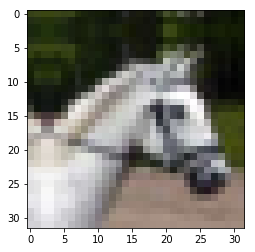

In [13]:
plt.imshow(data.trn_ds.denorm(x)[0])

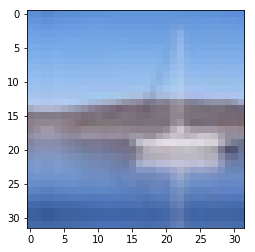

In [15]:
plt.imshow(data.trn_ds.denorm(x)[1])

## Fully Connected model

In [16]:
data = get_data(32,bs)

In [25]:
lr = 1e-2

From [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by a student Kerem Turgutlu:

In [18]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers =  nn.ModuleList([
            nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) -1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [19]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40, 10]), data)

In [20]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=10, bias=True)
   )
 ), [122880, 40, 400, 10])

In [21]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', tensor(122920))])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', tensor(410))]))])

In [22]:
learn.lr_find()

 75%|███████▌  | 147/196 [00:42<00:14,  3.48it/s, loss=2.66]

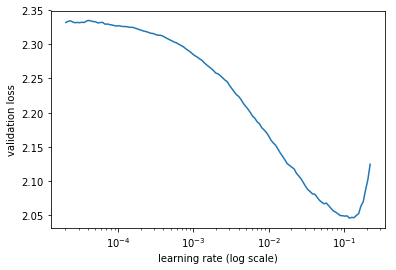

In [23]:
learn.sched.plot()

In [27]:
%time learn.fit(lr,2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.759975   1.667553   0.4074    
    1      1.674355   1.574935   0.4444                     
CPU times: user 20min 40s, sys: 4min 31s, total: 25min 11s
Wall time: 2min 11s


[1.5749346912384032, 0.4444]

In [28]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.611636   1.524995   0.4673    
    1      1.587995   1.501094   0.4756                     
CPU times: user 22min 53s, sys: 4min 41s, total: 27min 35s
Wall time: 2min 12s


[1.501094153213501, 0.4756]

## CNN

In [30]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i+1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool =  nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c) # c is the number of classes
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1) # flattened out
        return F.log_softmax(self.out(x), dim=-1)

In [31]:
learn = ConvLearner.from_model_data(ConvNet([3,20,40,80], 10), data)

In [32]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', tensor(560))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', tensor(7240))])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', tensor(28880))])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
 

image size is 32X32 as passed in `get_data(32,bs)`, due to stride 2 convolution each input is halfed in output 32 becomes 15 , 15 becomes 7, 7 becomes 3 etc.
AdaptiveMacpool is supplied 1 dimension so the result would be 1,1 that is from 3X3 cell find the max for just 1 cell


In [33]:
learn.lr_find(end_lr=100) #continue until you try all the way to 1

 72%|███████▏  | 141/196 [00:40<00:15,  3.47it/s, loss=2.56]

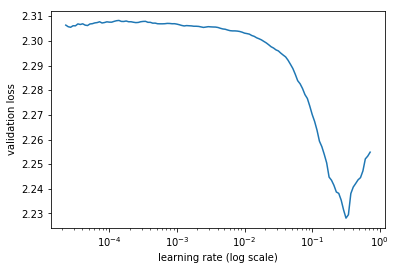

In [34]:
learn.sched.plot()

In [35]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.687905   1.552436   0.425     
    1      1.498552   1.410461   0.4896                     
CPU times: user 20min 38s, sys: 4min 11s, total: 24min 50s
Wall time: 1min 57s


[1.4104614298820495, 0.4896]

In [36]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.328188   1.253566   0.5491    
    1      1.268296   1.202061   0.5627                     
    2      1.219925   1.150023   0.5922                     
    3      1.203989   1.126672   0.6012                     
CPU times: user 42min 18s, sys: 8min 31s, total: 50min 49s
Wall time: 3min 58s


[1.1266717576026917, 0.6012]

## Refactored

In [37]:
class ConvLayer(nn.Module):
    def __init__(self,ni,nf):
        super().__init__()
        self.conv = nn.Conv2d(ni,nf,kernel_size=3,stride=2,padding=1)
        
    def forward(self,x): return F.relu(self.conv(x))

In [38]:
class ConvNet2(nn.Module):
    def __init__(self,layers, c):
        super().__init__()
        #instead of conv2d its wrapped in convlayer which was declared with padding in conv2d
        self.layers = nn.ModuleList([ 
                ConvLayer(layers[i], layers[i+1]) for i in range(len(layers) -1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [39]:
learn = ConvLearner.from_model_data(ConvNet2([3,20,40,80], 10), data) # starting 3 is RGB of pics

In [40]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(560))])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', tensor(7240))])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
 

Due to padding=1 in conv2d we get 32 to 16 , 16 to 8. This way there is no loss of data

In [41]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.684064   1.578191   0.4259    
    1      1.476117   1.471487   0.4608                     
CPU times: user 18min 11s, sys: 4min 6s, total: 22min 17s
Wall time: 1min 59s


[1.4714865509033204, 0.4608]

In [42]:
%time learn.fit(1e-1,2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.356252   1.269749   0.5378    
    1      1.261379   1.185514   0.5653                     
CPU times: user 24min 24s, sys: 4min 35s, total: 29min
Wall time: 1min 59s


[1.185514370727539, 0.5653]

## BatchNorm

In [43]:
class BnLayer(nn.Module):
    def __init__(self,ni,nf,stride=2,kernel_size=3):
        super().__init__()
        self.conv =  nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,bias=False,padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1)) #addition init with 0
        self.m = nn.Parameter(torch.ones(nf,1,1)) #multiply init with 1
        
    def forward(self,x):
        x = F.relu(self.conv(x))
        x_chan =  x.transpose(0,1).contiguous().view(x.size(1),-1)
        if self.training:
            self.means = x_chan.mean(1)[:, None, None]
            self.stds  = x_chan.std(1)[:, None, None]
        return (x-self.means) / self.stds * self.m + self.a 

In [44]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3,10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
                    for i in range(len(layers) -1) ])
        self.out =  nn.Linear(layers[-1],c)
        
    def forward(self,x):
        x= self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0),-1)
        return F.log_softmax(self.out(x), dim=-1)

Batchnorm is done so that weights are normalized for each batch using means and standard deviation. this helps the gradients to stay in control. while just adjusting at the forward would not work as SGD would reset it, a constant for additiion and multiplication is maintained and is learned through backprop and so is a torch parameter. This way from batch to batch that value changes to normalize the weights

In [45]:
learn = ConvLearner.from_model_data(ConvBnNet([10,20,40,80,160], 10), data)

In [46]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(760))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(1800))])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', tensor(7200))])),
             ('BnLayer-5',
   

In [47]:
%time learn.fit(3e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.523393   1.384107   0.4954    
    1      1.2727     1.135786   0.5989                     
CPU times: user 26min 32s, sys: 4min 31s, total: 31min 4s
Wall time: 1min 55s


[1.1357858227729798, 0.5989]

In [48]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.126649   1.018656   0.6384    
    1      1.016299   0.937991   0.677                      
    2      0.934428   0.879602   0.6919                      
    3      0.882379   0.807667   0.7166                      
CPU times: user 55min 13s, sys: 9min 55s, total: 1h 5min 9s
Wall time: 4min 16s


[0.8076671049118042, 0.7166]

## Deep BatchNorm

In [52]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 =  nn.Conv2d(3,10, kernel_size=5, stride=1, padding=2)
        self.layers =  nn.ModuleList([BnLayer(layers[i], layers[i+1]) 
                for i in range(len(layers) -1) ])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i+1],1)
                for i in range(len(layers) -1) ])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0),-1)
        return F.log_softmax(self.out(x), dim=-1)

In [53]:
learn = ConvLearner.from_model_data(ConvBnNet2([10,20,40,80,160], 10), data)

In [54]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(760))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(1800))])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(3600))])),
             ('BnLayer-5',
 

In [55]:
%time learn.fit(1e-2,2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.515386   1.360152   0.4989    
    1      1.270848   1.174688   0.5707                     
CPU times: user 35min 14s, sys: 5min 18s, total: 40min 33s
Wall time: 2min 5s


[1.1746878393173217, 0.5707]

In [56]:
%time learn.fit(1e-2,2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.085797   1.022197   0.6362    
    1      1.014736   0.940187   0.6674                     
CPU times: user 36min 28s, sys: 5min 30s, total: 41min 58s
Wall time: 2min 7s


[0.9401873281002044, 0.6674]

## Resnet

In [57]:
class ResnetLayer(BnLayer):
    def forward(self,x): return x+ super().forward(x)

In [58]:
class Resnet(nn.Module):
    def __init__(self,layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers =  nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) -1) ])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1)
            for i in range(len(layers) -1) ])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1)
            for i in range(len(layers) -1) ])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [59]:
learn = ConvLearner.from_model_data(Resnet([10,20,40,80,160], 10), data)

In [60]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(760))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(1800))])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(3600))])),
             ('ResnetLayer-5

In [61]:
wd = 1e-5

In [62]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.573312   1.432046   0.4766    
    1      1.348989   1.255765   0.5514                     
CPU times: user 43min 38s, sys: 6min, total: 49min 39s
Wall time: 2min 7s


[1.2557646909713744, 0.5514]

In [63]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.134452   1.083882   0.6141    
    1      1.100927   1.035977   0.6371                     
    2      0.978077   0.937053   0.6672                      
    3      1.006665   1.053593   0.6366                     
    4      0.912458   0.84894    0.701                       
    5      0.805046   0.783427   0.7247                      
    6      0.773261   0.783256   0.7203                      
CPU times: user 2h 34min 2s, sys: 20min 46s, total: 2h 54min 48s
Wall time: 7min 21s


[0.7832563514232636, 0.7203]

In [64]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.888104   0.881957   0.6943    
    1      0.773263   0.783708   0.7312                      
    2      0.699388   0.698796   0.7579                      
    3      0.653955   0.68904    0.7579                      
    4      0.754054   0.748516   0.7395                      
    5      0.678244   0.694471   0.7623                      
    6      0.616421   0.651718   0.7717                      
    7      0.577934   0.64748    0.779                       
    8      0.686631   0.722389   0.7518                      
    9      0.61072    0.676367   0.7711                      
    10     0.551994   0.594652   0.7938                      
    11     0.519187   0.641986   0.7823                      
    12     0.626999   0.663972   0.7734                      
    13     0.561375   0.637836   0.7853                      
    14     0.492333   0.588931   0.7999                      
    15     0.46562    0.56

[0.5336285980701446, 0.8263]

## Resnet 2

In [77]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3,16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer( layers[i], layers[i+1])
             for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1)
             for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1)
             for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self,x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [78]:
learn = ConvLearner.from_model_data(Resnet2([16,32,64,128,256], 10, 0.2), data)

In [98]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 16, 28, 28]),
                           ('trainable', True),
                           ('nb_params', tensor(2352))])),
             ('BnLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 16, 28, 28]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 16, 28, 28]),
                           ('output_shape', [-1, 32, 14, 14]),
                           ('trainable', True),
                           ('nb_params', tensor(4608))])),
             ('BnLayer-4',
              OrderedDict([('input_shape', [-1, 16, 28, 28]),
                           ('output_shape', [-1, 32, 14, 14]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 32, 14, 14])

In [79]:
wd=1e-6

In [80]:
%time learn.fit(1e-2,2,wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.713746   1.561344   0.4462    
    1      1.471304   1.369955   0.5089                     
CPU times: user 41min 47s, sys: 5min 30s, total: 47min 18s
Wall time: 1min 57s


[1.369954591369629, 0.5089]

In [81]:
%time learn.fit(1e-2,3,cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.223216   1.109066   0.6028    
    1      1.165695   1.045115   0.6312                     
    2      1.006238   0.957878   0.662                      
    3      1.074888   1.013012   0.6477                     
    4      0.950768   0.930322   0.6691                      
    5      0.850608   0.832099   0.7147                      
    6      0.794877   0.803238   0.7174                      
CPU times: user 2h 36min 23s, sys: 21min 1s, total: 2h 57min 24s
Wall time: 7min 23s


[0.8032381049156189, 0.7174]

In [82]:
%time learn.fit(1e-2,8,cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.931374   0.860381   0.6971    
    1      0.842952   0.797929   0.7277                      
    2      0.744915   0.722513   0.7475                      
    3      0.689558   0.720829   0.7494                      
    4      0.811252   0.769062   0.7282                      
    5      0.729984   0.692456   0.7566                      
    6      0.641897   0.662905   0.7684                      
    7      0.603965   0.643668   0.7808                      
    8      0.721704   0.718076   0.7571                      
    9      0.645228   0.644614   0.7738                      
    10     0.57394    0.607295   0.7902                      
    11     0.533854   0.632961   0.7836                      
    12     0.661986   0.651949   0.7765                      
    13     0.591229   0.623563   0.7842                      
    14     0.534871   0.606659   0.7899                      
    15     0.496851   0.58

[0.52232974858284, 0.829]

In [83]:
learn.save('tmp3')

In [84]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [87]:
y, y.shape

(array([0, 0, 0, ..., 9, 9, 9]), (10000,))

In [97]:
log_preds.shape, preds.shape

((5, 10000, 10), (10000, 10))

In [94]:
len(np.exp(log_preds)),  len(np.mean(np.exp(log_preds),0))

(5, 10000)

In [85]:
metrics.log_loss(y,preds), accuracy_np(preds,y)

(0.46102912714432576, 0.8447)

## End